In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import shutil
import tempfile

from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

2025-08-03 16:40:43.381176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754239243.583200      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754239243.646135      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

base_dir = '/kaggle/input/brain-tumor-image-clasification/'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Val')

In [3]:
IMG_SIZE = (260, 260)
BATCH_SIZE = 16
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 15

# Data Preprocessing

In [4]:
def get_file_paths_and_labels(data_dir):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_to_idx[class_name])
    
    return file_paths, labels, class_names

In [5]:
train_file_paths, train_labels, class_names = get_file_paths_and_labels(train_dir)
print(f"Total training files: {len(train_file_paths)}")
print(f"Class names: {class_names}")
num_classes = len(class_names)

Total training files: 4737
Class names: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


In [6]:
train_paths, val_paths, train_labels_split, val_labels_split = train_test_split(
    train_file_paths,
    train_labels,
    test_size=0.3,
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

Training samples: 3315
Validation samples: 1422


In [7]:
train_label_counts = Counter(train_labels_split)
val_label_counts = Counter(val_labels_split)

print("\nClass distribution after split:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Train={train_label_counts[i]}, Val={val_label_counts[i]}")


Class distribution after split:
Glioma: Train=807, Val=346
Meningioma: Train=1014, Val=435
No Tumor: Train=498, Val=213
Pituitary: Train=996, Val=428


In [8]:
temp_dir = tempfile.mkdtemp()
temp_train_dir = os.path.join(temp_dir, 'train')
temp_val_dir = os.path.join(temp_dir, 'val')

# Create class subdirectories
for class_name in class_names:
    os.makedirs(os.path.join(temp_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(temp_val_dir, class_name), exist_ok=True)

for file_path, label in zip(train_paths, train_labels_split):
    class_name = class_names[label]
    dest_path = os.path.join(temp_train_dir, class_name, os.path.basename(file_path))
    shutil.copy2(file_path, dest_path)

for file_path, label in zip(val_paths, val_labels_split):
    class_name = class_names[label]
    dest_path = os.path.join(temp_val_dir, class_name, os.path.basename(file_path))
    shutil.copy2(file_path, dest_path)

In [9]:
train_dataset = image_dataset_from_directory(
    temp_train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=seed_value
)

validation_dataset = image_dataset_from_directory(
    temp_val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False,
    seed=seed_value
)

# Test dataset remains the same
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

Found 3315 files belonging to 4 classes.


I0000 00:00:1754239282.103688      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1422 files belonging to 4 classes.
Found 512 files belonging to 4 classes.


In [10]:
def count_classes(dataset, class_names):
    total = np.zeros(len(class_names), dtype=int)

    for images, labels in dataset:
        batch_counts = labels.numpy().sum(axis=0)
        total += batch_counts.astype(int)

    return dict(zip(class_names, total))

# Count for each dataset
train_counts = count_classes(train_dataset, class_names)
val_counts = count_classes(validation_dataset, class_names)

print("Train counts:", train_counts)
print("Validation counts:", val_counts)

Train counts: {'Glioma': 807, 'Meningioma': 1014, 'No Tumor': 498, 'Pituitary': 996}
Validation counts: {'Glioma': 346, 'Meningioma': 435, 'No Tumor': 213, 'Pituitary': 428}


## Sample Image

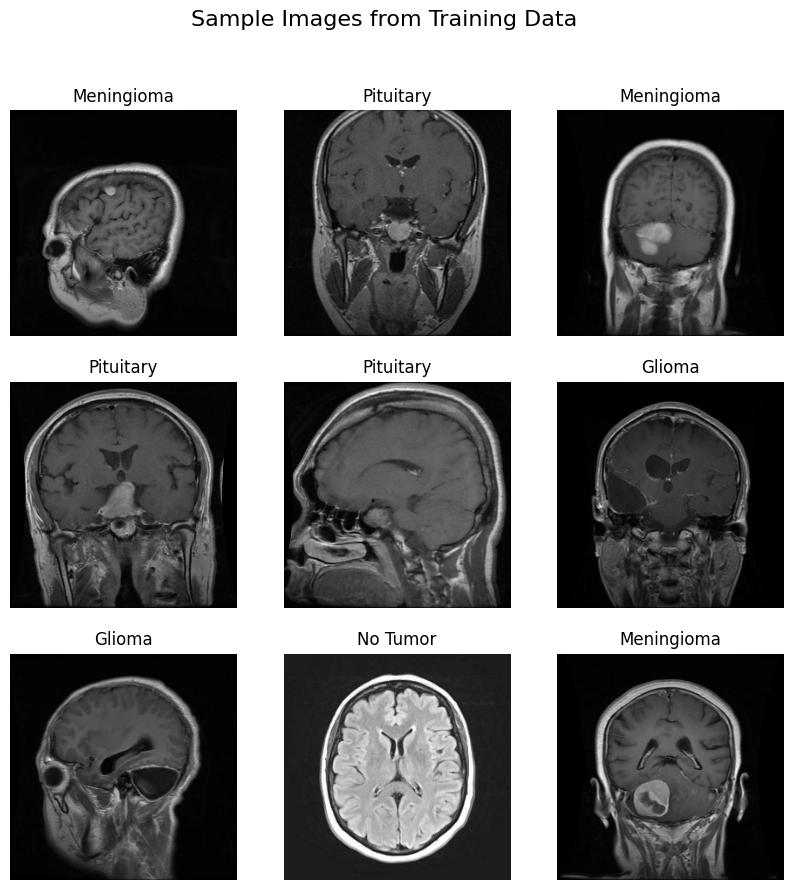

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Sample Images from Training Data", fontsize=16)
plt.show()

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation")

# Baseline Model

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = EfficientNetB2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE, name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_avg_pool")(x)
x = Dropout(0.3, name="dropout_1")(x)
outputs = Dense(num_classes, activation='softmax', name="output_layer")(x)
model = Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(
    optimizer=Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 9, 9, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,774,205 (29.66 MB)

 Trainable params: 5,636 (22.02 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [15]:
baseline_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

baseline_checkpoint = ModelCheckpoint(
    filepath='baseline_model_last.keras',
    save_best_only=False,
    monitor='val_accuracy',
    verbose=1
)

In [16]:
print("\n--- Baseline Training (Frozen Backbone) ---")
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
    callbacks=[baseline_early_stopping, baseline_checkpoint]
)

end_time = time.time()
print(f"Baseline training took: {((end_time - start_time) / 60):.2f} minutes")

baseline_model = load_model('/kaggle/working/baseline_model_last.keras')


--- Baseline Training (Frozen Backbone) ---
Epoch 1/20


E0000 00:00:1754239315.167512      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754239318.137176     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5887 - loss: 0.9424
Epoch 1: saving model to baseline_model_last.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - accuracy: 0.5893 - loss: 0.9415 - val_accuracy: 0.8333 - val_loss: 0.5054
Epoch 2/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8041 - loss: 0.5357
Epoch 2: saving model to baseline_model_last.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8042 - loss: 0.5354 - val_accuracy: 0.8383 - val_loss: 0.4263
Epoch 3/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8208 - loss: 0.4617
Epoch 3: saving model to baseline_model_last.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.8209 - loss: 0.4617 - val_accuracy: 0.8622 - val_loss: 0.3830
Epoch 4/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8392 - loss: 0.4172
Epoch 4: saving model to baseline_model_last.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.8393 - loss: 0.4171 - val_accuracy: 0.8594 -

## Evaluating Baseline

In [17]:
def plot_training_history(tr_acc, tr_loss, val_acc, val_loss):
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 8), facecolor='white')

    # Loss plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_facecolor('white')
    ax1.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=4)
    ax1.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=4)
    ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=14)
    ax1.grid(True)

    # Accuracy plot
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_facecolor('white')
    ax2.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
    ax2.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
    ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    ax2.set_title('Training and Validation Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(fontsize=14)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

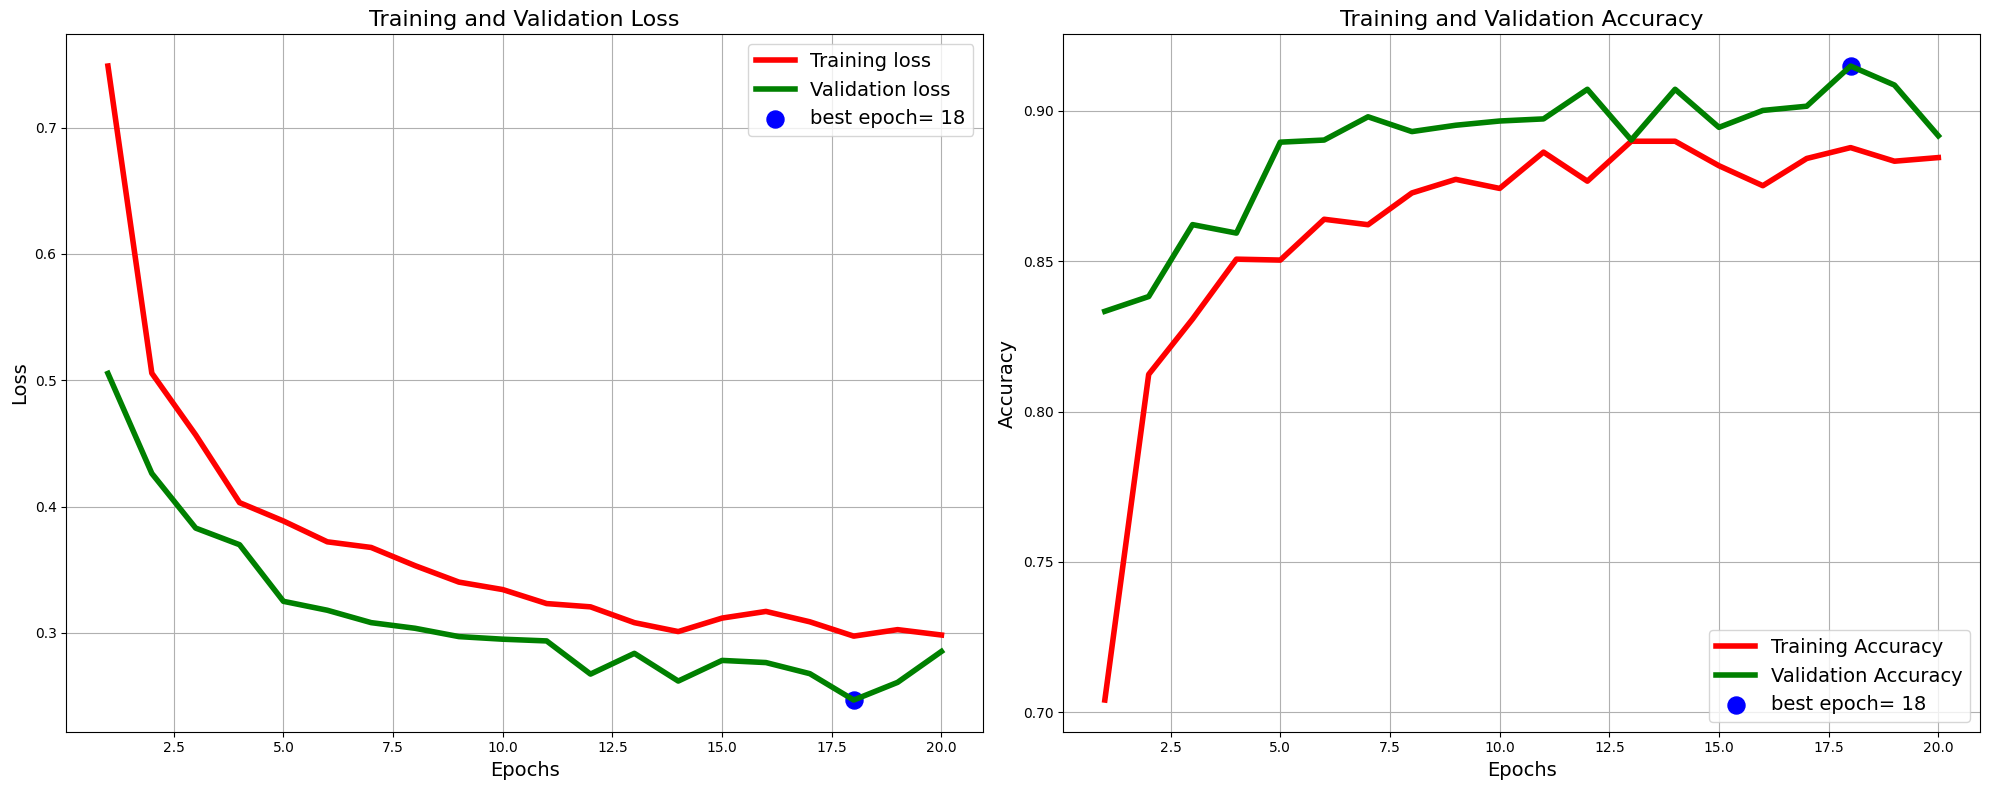

In [18]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plot_training_history(tr_acc, tr_loss, val_acc, val_loss)

In [19]:
def evaluate_model(model, dataset, dataset_name, class_names, use_cache=False):
    print(f"\n--- Evaluating {dataset_name} set ---")
    
    all_images = []
    all_labels = []
    for batch_images, batch_labels in dataset:
        all_images.append(batch_images.numpy())
        all_labels.append(batch_labels.numpy())
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    print(f"Total samples collected: {len(all_images)}")
    
    # Get predictions
    y_pred_probs = model.predict(all_images, verbose=1, batch_size=BATCH_SIZE)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    # Get true classes
    y_true_classes = np.argmax(all_labels, axis=1)

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Calculate accuracy
    accuracy = np.mean(y_true_classes == y_pred_classes)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percent,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - {dataset_name} (%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, y_true_classes, y_pred_classes


--- Evaluating Baseline Model on Training Data set ---
Total samples collected: 3315
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step

Classification Report for Baseline Model on Training Data:
              precision    recall  f1-score   support

      Glioma       0.88      0.94      0.91       807
  Meningioma       0.94      0.77      0.85      1014
    No Tumor       0.98      0.93      0.96       498
   Pituitary       0.86      0.99      0.92       996

    accuracy                           0.90      3315
   macro avg       0.92      0.91      0.91      3315
weighted avg       0.91      0.90      0.90      3315

Overall Accuracy: 0.9026


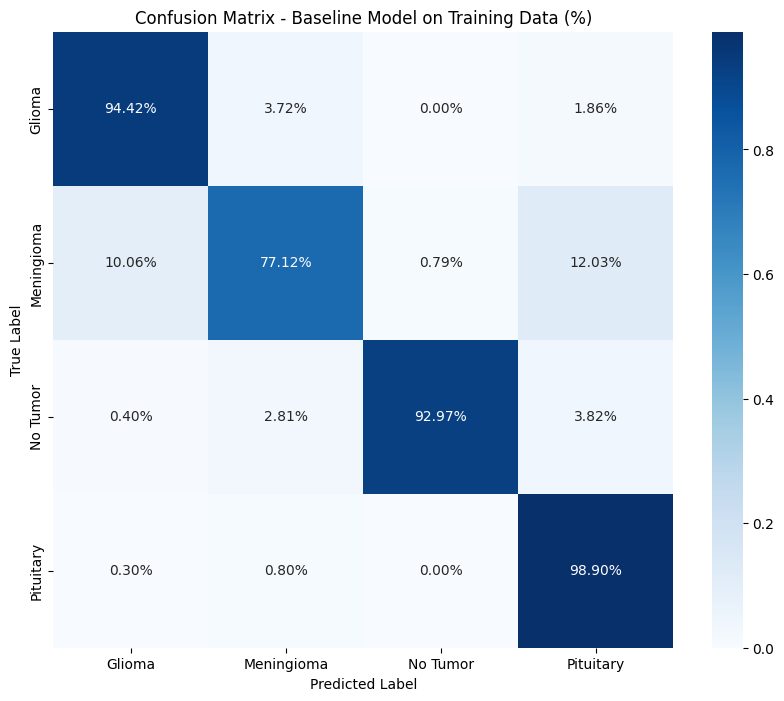


--- Evaluating Baseline Model on Validation Data set ---
Total samples collected: 1422
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step

Classification Report for Baseline Model on Validation Data:
              precision    recall  f1-score   support

      Glioma       0.84      0.92      0.88       346
  Meningioma       0.91      0.76      0.83       435
    No Tumor       0.99      0.92      0.95       213
   Pituitary       0.88      0.99      0.93       428

    accuracy                           0.89      1422
   macro avg       0.90      0.90      0.90      1422
weighted avg       0.90      0.89      0.89      1422

Overall Accuracy: 0.8917


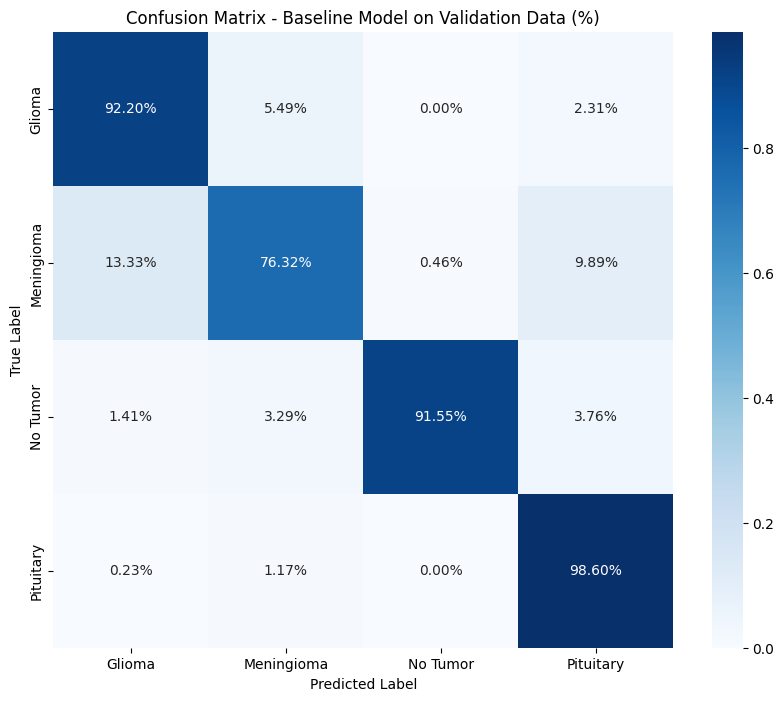


--- Evaluating Baseline Model on Test Data set ---
Total samples collected: 512
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

Classification Report for Baseline Model on Test Data:
              precision    recall  f1-score   support

      Glioma       0.86      0.90      0.88       136
  Meningioma       0.85      0.78      0.81       140
    No Tumor       0.99      0.87      0.93       100
   Pituitary       0.86      0.96      0.91       136

    accuracy                           0.88       512
   macro avg       0.89      0.88      0.88       512
weighted avg       0.88      0.88      0.88       512

Overall Accuracy: 0.8789


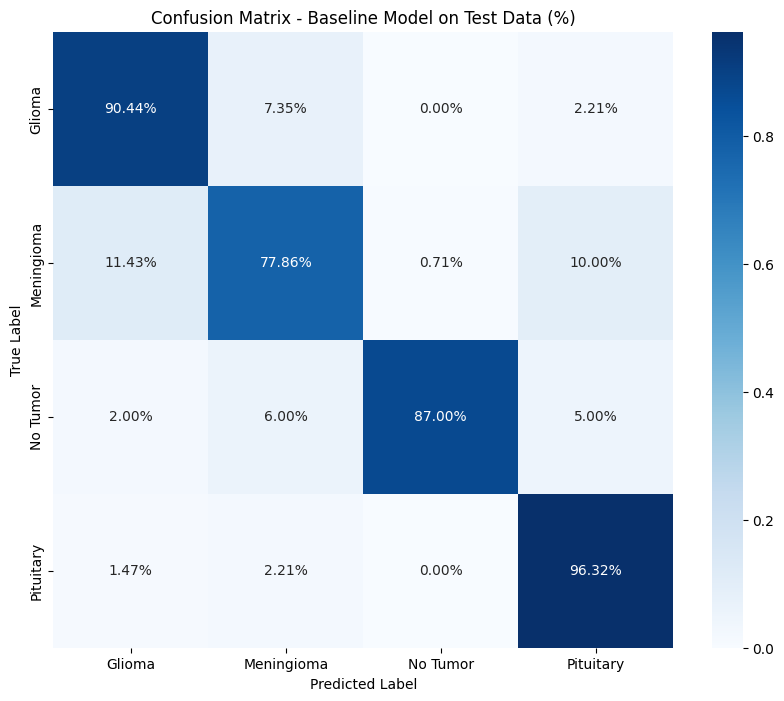


=== Summary ===
Training Accuracy: 0.9026
Validation Accuracy: 0.8917
Test Accuracy: 0.8789


In [20]:
train_acc, _, _ = evaluate_model(baseline_model, train_dataset, "Baseline Model on Training Data", class_names)
val_acc, _, _ = evaluate_model(baseline_model, validation_dataset, "Baseline Model on Validation Data", class_names)
test_acc, _, _ = evaluate_model(baseline_model, test_dataset, "Baseline Model on Test Data", class_names)

print(f"\n=== Summary ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Fine Tuned Model

In [21]:
base_model.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

baseline_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
baseline_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 9, 9, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         5,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,774,205 (29.66 MB)

 Trainable params: 5,636 (22.02 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [22]:
finetune_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=7,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

finetune_checkpoint = ModelCheckpoint(
    filepath='finetune_model_tune.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    epsilon=0.001,
    verbose=1
)

In [23]:
print("\n--- Fine-Tuning (Unfrozen Top Layers) ---")
start_time = time.time()

history_fine = baseline_model.fit(
    train_dataset, 
    epochs=FINE_TUNE_EPOCHS, 
    validation_data=validation_dataset, 
    callbacks=[finetune_early_stopping, finetune_checkpoint, reduce_lr])

end_time = time.time()
print(f"Baseline training took: {((end_time - start_time) / 60):.2f} minutes")

tune_model = load_model('/kaggle/working/finetune_model_tune.keras')


--- Fine-Tuning (Unfrozen Top Layers) ---
Epoch 1/15


E0000 00:00:1754239768.072771      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8819 - loss: 0.3210
Epoch 1: val_accuracy improved from -inf to 0.90225, saving model to finetune_model_tune.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 50s 122ms/step - accuracy: 0.8819 - loss: 0.3208 - val_accuracy: 0.9023 - val_loss: 0.2618 - learning_rate: 1.0000e-04
Epoch 2/15
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8860 - loss: 0.2859
Epoch 2: val_accuracy did not improve from 0.90225
208/208 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.8860 - loss: 0.2859 - val_accuracy: 0.9015 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 3/15
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8857 - loss: 0.3013
Epoch 3: val_accuracy improved from 0.90225 to 0.90295, saving model to finetune_model_tune.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.8858 - loss: 0.3013 - val_accuracy: 0.9030 - val_loss: 0.2568 - learning_rate: 1.0000e-04
Epoch 4/15
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy:

## Evaluating FineTuned

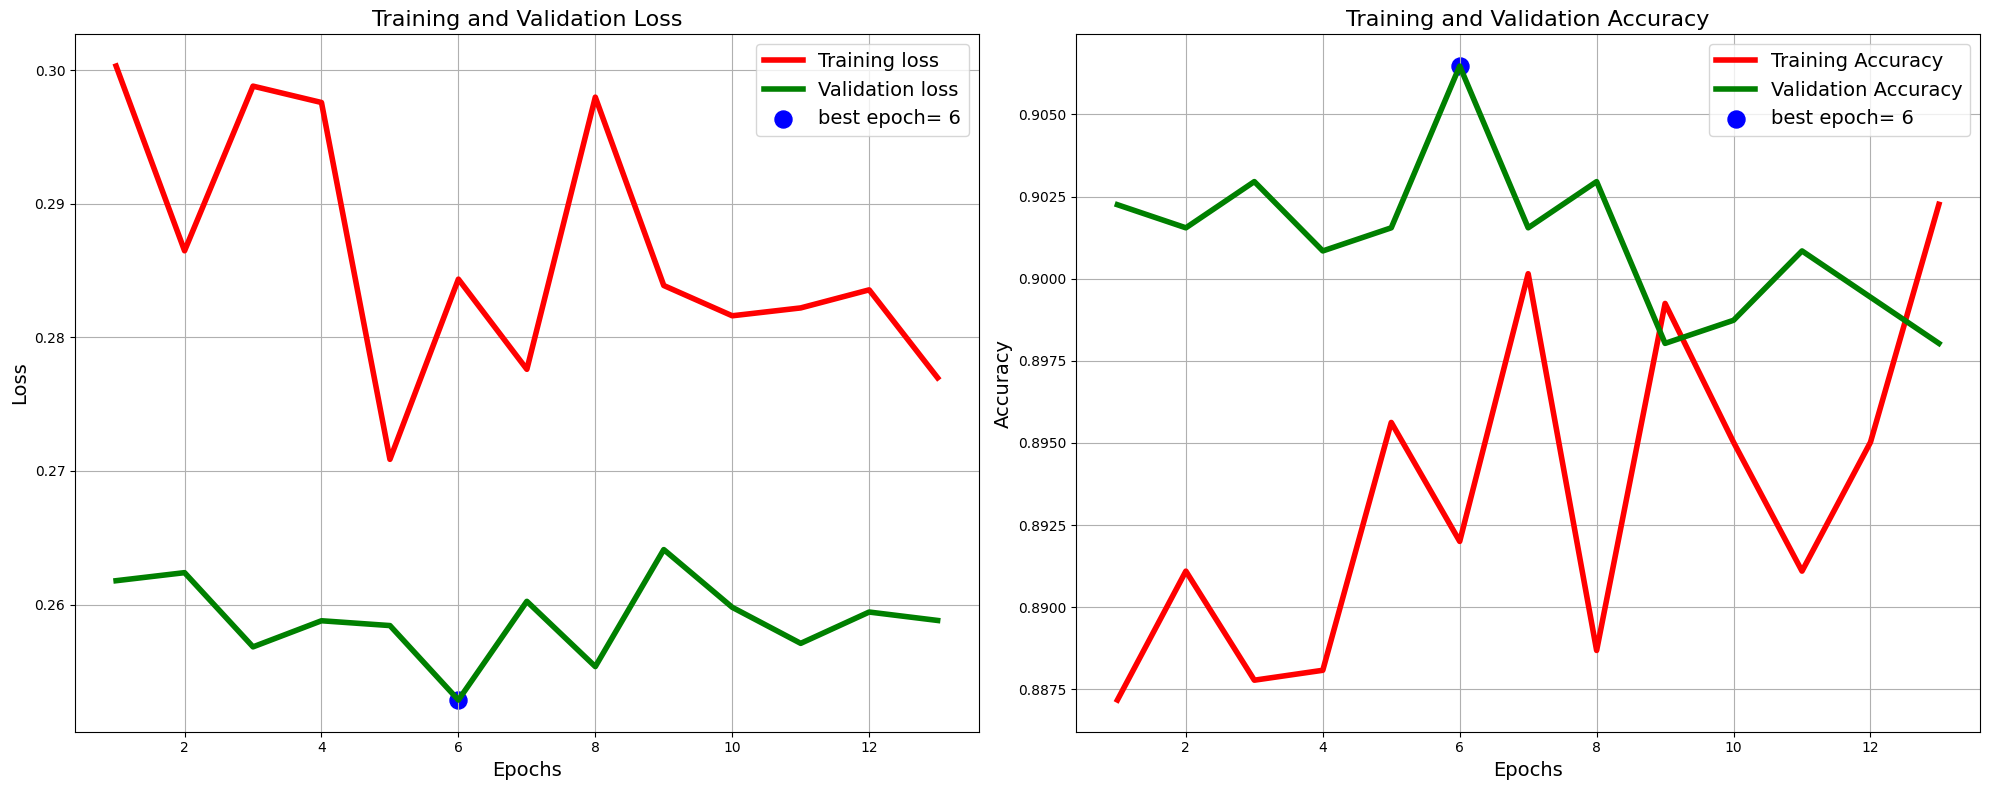

In [24]:
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']

plot_training_history(tr_acc, tr_loss, val_acc, val_loss)


--- Evaluating Tuned Model on Training Data set ---
Total samples collected: 3315
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step

Classification Report for Tuned Model on Training Data:
              precision    recall  f1-score   support

      Glioma       0.89      0.94      0.92       807
  Meningioma       0.93      0.82      0.87      1014
    No Tumor       0.98      0.96      0.97       498
   Pituitary       0.91      0.98      0.95       996

    accuracy                           0.92      3315
   macro avg       0.93      0.93      0.93      3315
weighted avg       0.92      0.92      0.92      3315

Overall Accuracy: 0.9210


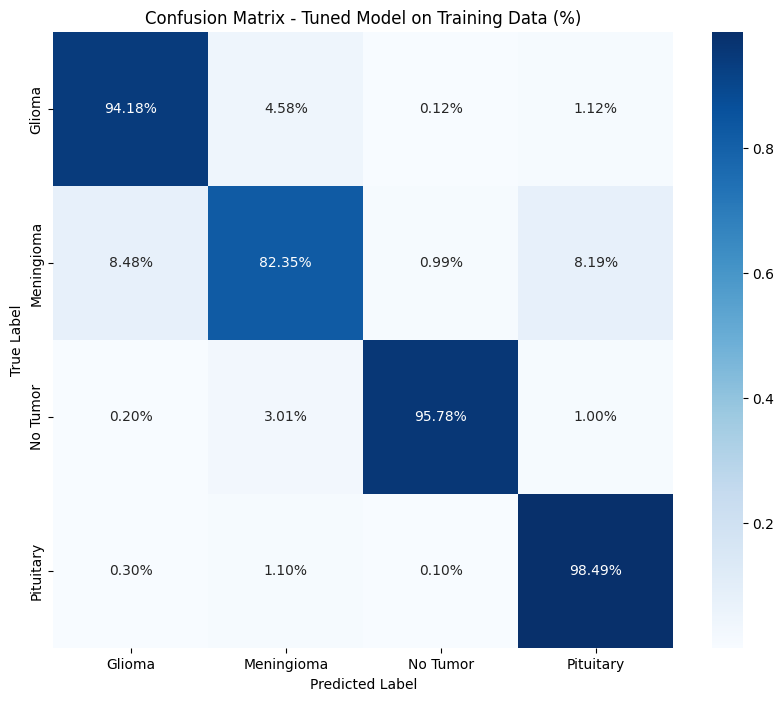


--- Evaluating Tuned Model on Validation Data set ---
Total samples collected: 1422
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step

Classification Report for Tuned Model on Validation Data:
              precision    recall  f1-score   support

      Glioma       0.84      0.92      0.88       346
  Meningioma       0.91      0.80      0.85       435
    No Tumor       0.99      0.93      0.96       213
   Pituitary       0.92      0.99      0.95       428

    accuracy                           0.91      1422
   macro avg       0.92      0.91      0.91      1422
weighted avg       0.91      0.91      0.91      1422

Overall Accuracy: 0.9065


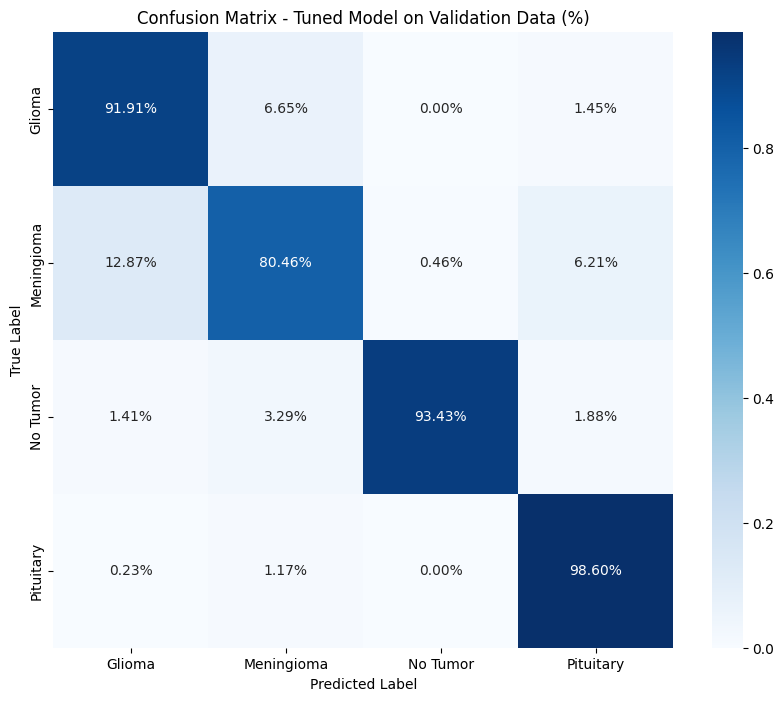


--- Evaluating Tuned Model on Test Data set ---
Total samples collected: 512
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

Classification Report for Tuned Model on Test Data:
              precision    recall  f1-score   support

      Glioma       0.88      0.90      0.89       136
  Meningioma       0.86      0.81      0.83       140
    No Tumor       0.99      0.92      0.95       100
   Pituitary       0.89      0.96      0.92       136

    accuracy                           0.90       512
   macro avg       0.90      0.90      0.90       512
weighted avg       0.90      0.90      0.90       512

Overall Accuracy: 0.8965


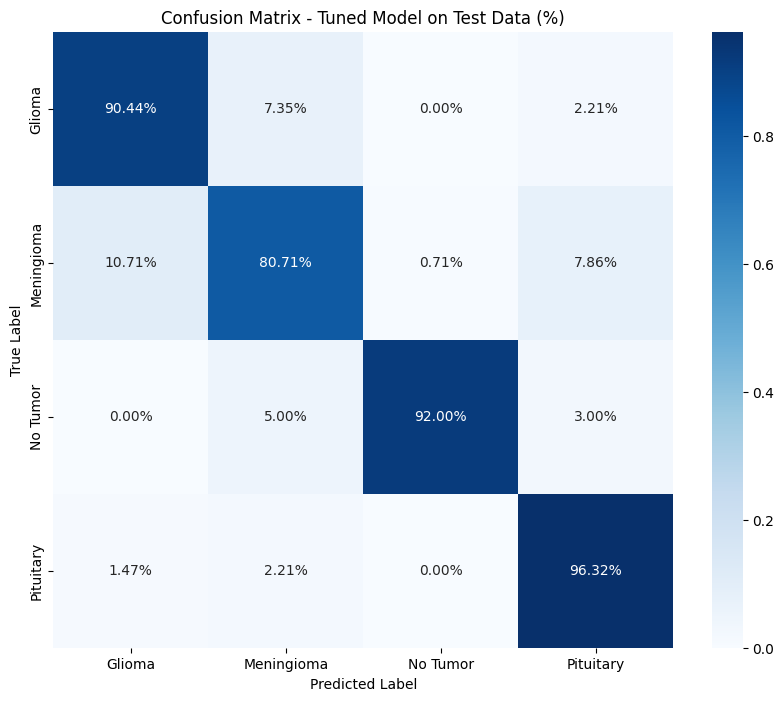


=== Summary ===
Training Accuracy: 0.9210
Validation Accuracy: 0.9065
Test Accuracy: 0.8965


In [25]:
train_acc, _, _ = evaluate_model(tune_model, train_dataset, "Tuned Model on Training Data", class_names)
val_acc, _, _ = evaluate_model(tune_model, validation_dataset, "Tuned Model on Validation Data", class_names)
test_acc, _, _ = evaluate_model(tune_model, test_dataset, "Tuned Model on Test Data", class_names)

print(f"\n=== Summary ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")